# A quickstart for Mitsuba building blocks

In [1]:
from typing import *
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
# %matplotlib widget

import drjit as dr
import mitsuba as mi

from util import show_ray

## 2. Ray intersection: `mi.Ray3f` class and `mi.Scene.ray_intersect` method
First, generate a example scene using `mi.cornell_box()`. A Mitsuba function `mi.load_dict` will convert a Python dictionary to a certain type of Mitsuba object.

See more:
* https://github.com/mitsuba-renderer/mitsuba3/blob/7d91235d5c5d5273de8011746fb480d9662181d0/src/python/python/util.py#L565

In [2]:
mi.set_variant("scalar_rgb")
# mi.set_variant("cuda_ad_rgb", "llvm_ad_rgb")

scene_dict = mi.cornell_box()
scene = mi.load_dict(scene_dict)
print(f"{type(scene) = }")

type(scene) = <class 'mitsuba.scalar_rgb.Scene'>


`mi.Ray3f` is a class for *rays*, which consist of origin points and direction vectors.

`mi.Scene.ray_intersect` method performs the ray intersection query. Note that it returns not only intersection point location, but a structure named `mi.SurfaceInteraction3f` which consists of several information of the ray intersection query.

In [3]:
print("# mi.Ray3f object")
ray = mi.Ray3f((0, 0, 0), (1,1,0)/np.sqrt(2))
print(f"{type(ray) = }")
print(ray)
print(ray.o)
print(ray.d)

print("\n# mi.Scene.ray_intersect method and mi.SurfaceInteraction3f object")
si = scene.ray_intersect(ray)
print(f"{type(si) = }")
assert isinstance(si, mi.SurfaceInteraction3f)

# mi.Ray3f object
type(ray) = <class 'mitsuba.scalar_rgb.Ray3f'>
Ray3f[
  o = [0, 0, 0],
  d = [0.707107, 0.707107, 0],
  maxt = 3.40282e+38,
  time = 0,
]
[0.0, 0.0, 0.0]
[0.7071067690849304, 0.7071067690849304, 0.0]

# mi.Scene.ray_intersect method and mi.SurfaceInteraction3f object
type(si) = <class 'mitsuba.scalar_rgb.SurfaceInteraction3f'>


In [4]:
print(si)

SurfaceInteraction[
  t = 1.41421,
  time = 0,
  wavelengths = [],
  p = [1, 1, 2.6054e-15],
  shape = Rectangle[
    to_world = [[-4.37114e-08, 0, -1, 1],
                [0, 1, 0, 0],
                [1, 0, -4.37114e-08, 0],
                [0, 0, 0, 1]],
    frame = Frame[
      s = [-8.74228e-08, 0, 2],
      t = [0, 2, 0],
      n = [-1, 0, -4.37114e-08]
    ],
    surface_area = 4,
    bsdf = SmoothDiffuse[
      reflectance = SRGBReflectanceSpectrum[
        value = [0.105421, 0.37798, 0.076425]
      ]
    ]
  ],
  uv = [0.5, 1],
  n = [-1, 0, -4.37114e-08],
  sh_frame = Frame[
    s = [-4.37114e-08, 0, 1],
    t = [0, 1, 0],
    n = [-1, 0, -4.37114e-08]
  ],
  dp_du = [-8.74228e-08, 0, 2],
  dp_dv = [0, 2, 0],
  wi = [3.09086e-08, -0.707107, 0.707107],
  prim_index = 0,
  instance = nullptr
]


If and only if ray hits a point on a surface, then `si.is_valid()` has `True` value.

In [5]:
si.is_valid()

True

### Visualize ray intersection
The following block visualizes a ray instance and the result of ray intersection. See also the printed text carefully. Please do not confuse that `si.wi` is written respect to the local frame of the intersection point.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


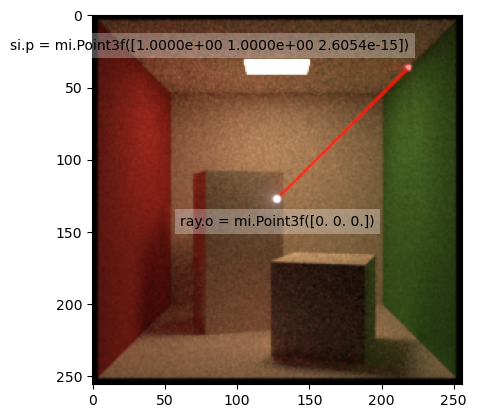

In [6]:
plt.figure()
show_ray(scene_dict, ray, si)
plt.show()

See constraints of attributes of `ray: mi.Ray3f` and `si: mi.SurfaceInteraction3f` below.

In [59]:
assert dr.allclose(si.p, ray.o + si.t * ray.d)
print("si.p == ray.o + si.t * ray.d")

assert not dr.allclose(ray.d, si.wi)
assert not dr.allclose(-ray.d, si.wi)
assert not dr.allclose(ray.d, si.sh_frame.to_world(si.wi))
assert dr.allclose(-ray.d, si.to_world(si.wi))
assert dr.allclose(-ray.d, si.sh_frame.to_world(si.wi))
print("-ray.d == si.sh_frame.to_world(si.wi)")

si.p == ray.o + si.t * ray.d
-ray.d == si.sh_frame.to_world(si.wi)


### Attributes for no intersection
When the scene has an environment light, we should utilize several information from `si = scene.ray_intersect(ray)` whenever `si.is_valid() == False`.

In [11]:
rayinf = mi.Ray3f([0, 0, 1], [0, 1, 0])
siinf1 = scene.ray_intersect(rayinf)
print(f"{siinf1 = }")

scene2 = mi.cornell_box()
scene2['envmap'] = {'type': 'constant', 'radiance': {
    'type': 'rgb',
    'value': 0.8,
}}
scene2 = mi.load_dict(scene2)
siinf2 = scene2.ray_intersect(rayinf)
print(f"{siinf2 = }")

siinf1 = SurfaceInteraction[invalid]
siinf2 = SurfaceInteraction[invalid]


In [23]:
print(f"{siinf1.p = }")
print(f"{siinf1.n = }")
print(f"{siinf1.t = }")
print(f"{siinf1.wi = }") # Important, while other attributes will not be used
print(f"{siinf1.sh_frame = }")
print(f"{siinf1.shape = }")

assert (siinf1.p == siinf2.p) and (siinf1.n == siinf2.n) and (siinf1.t == siinf2.t) and (siinf1.wi == siinf2.wi)
assert (siinf1.sh_frame == siinf2.sh_frame) and (siinf1.shape == siinf2.shape)

siinf1.p = [0.0, 0.0, 0.0]
siinf1.n = [0.0, 0.0, 0.0]
siinf1.t = inf
siinf1.wi = [-0.0, -1.0, -0.0]
siinf1.sh_frame = Frame[
  s = [0, 0, 0],
  t = [0, 0, 0],
  n = [0, 0, 0]
]
siinf1.shape = None


In [43]:
assert siinf1.emitter(scene) is None

emit = siinf2.emitter(scene2)
print(f"{type(emit) = }")
assert type(emit) == mi.Emitter
print(f"{emit = }")

type(emit) = <class 'mitsuba.scalar_rgb.Emitter'>
emit = ConstantBackgroundEmitter[
  radiance = SRGBReflectanceSpectrum[
    value = [0.8, 0.8, 0.8]
  ],
  bsphere = BoundingSphere3f[
    center = [0, -0.005, 0],
    radius = 1.7351
  ]
]


In [44]:
emit.eval(siinf2) # == siinf2.emitter(scene2).eval(siinf2)

[0.800000011920929, 0.800000011920929, 0.800000011920929]

### `mi.SurfaceInteraction3f` attributes summary
| attribute     | type          | `si.is_valid() == True`                                      | `si.is_valid() == False` |
| ------------- | ------------- | ------------------------------------------------------------ | ------------------------ |
| `si.p`        | `mi.Point3f`  | Position (world), `ray.o + si.t * ray.d`                     | N/A                      |
| `si.n`        | `mi.Normal3f` | Normal (world)                                               | N/A                      |
| `si.t`        | `mi.Float`    | \|`ray.o-si.p`\|                                             | `inf`                    |
| `si.wi`       | `mi.Vector3f` | Direction from `si.p` to `ray.o` (local)                     | `-ray.d` (world)         |
| `si.sh_frame` | `mi.Frame3f`  | `si.to_local` is `si.sh_frame.to_local`<br />`si.to_world` is `si.sh_frame.to_world`<br />`-ray.d == si.to_world(si.wi)` | N/A                      |


